Dataset:- https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

# STEP 1: IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

# STEP 2: LOAD DATASET

In [2]:
df = pd.read_csv("Mall_Customers.csv")

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
print(f"✓ Dataset loaded: {df.shape}")
print(f"✓ Customers: {len(df)}")

✓ Dataset loaded: (200, 5)
✓ Customers: 200


# STEP 3: PREPARE DATA (SAME AS K-MEANS)

In [5]:
# Select features (Income + Spending Score)
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

print(f"✓ Features selected: Annual Income + Spending Score")
print(f"✓ Shape: {X.shape}")

✓ Features selected: Annual Income + Spending Score
✓ Shape: (200, 2)


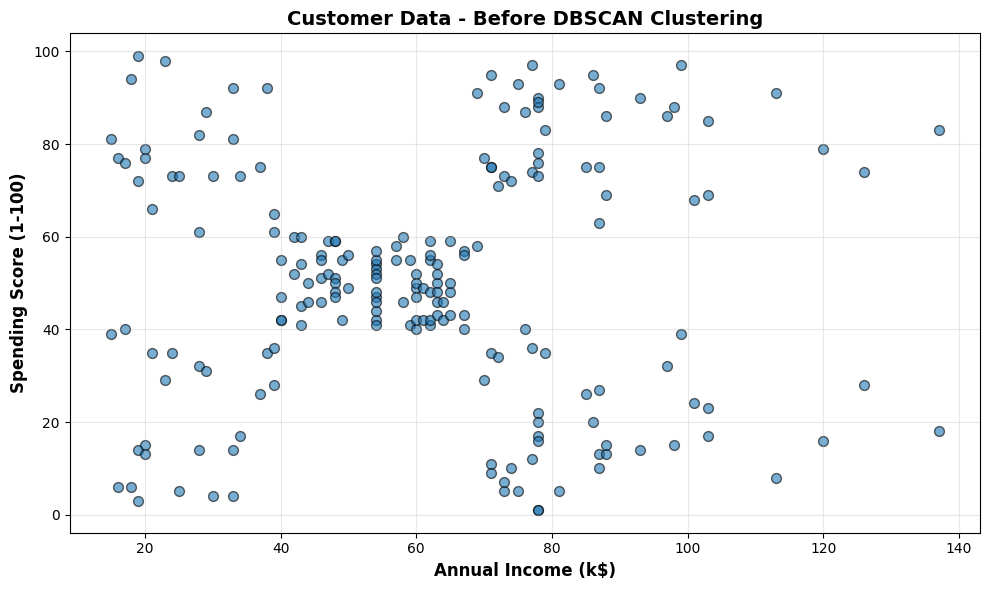

In [6]:
# Visualize before clustering
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolors='black')
plt.xlabel('Annual Income (k$)', fontweight='bold', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontweight='bold', fontsize=12)
plt.title('Customer Data - Before DBSCAN Clustering', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# STEP 4: FEATURE SCALING (IMPORTANT FOR DBSCAN!)

### ⚠️ DBSCAN uses DISTANCE - scaling is CRITICAL!"
   • Without scaling: Features with large ranges dominate"
   
   • With scaling: All features contribute equally to distance"

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n✓ Features scaled with StandardScaler")
print(f"✓ Mean: {X_scaled.mean(axis=0)}")
print(f"✓ Std: {X_scaled.std(axis=0)}")


✓ Features scaled with StandardScaler
✓ Mean: [-2.13162821e-16 -1.46549439e-16]
✓ Std: [1. 1.]


# STEP 5: FIND OPTIMAL EPS (K-DISTANCE GRAPH)

💡 K-Distance Graph Method:"

   • For each point, find distance to its k-th nearest neighbor"

   • Sort distances in ascending order"

   • Look for 'elbow' where distance increases sharply"

   • This elbow point = optimal eps!"

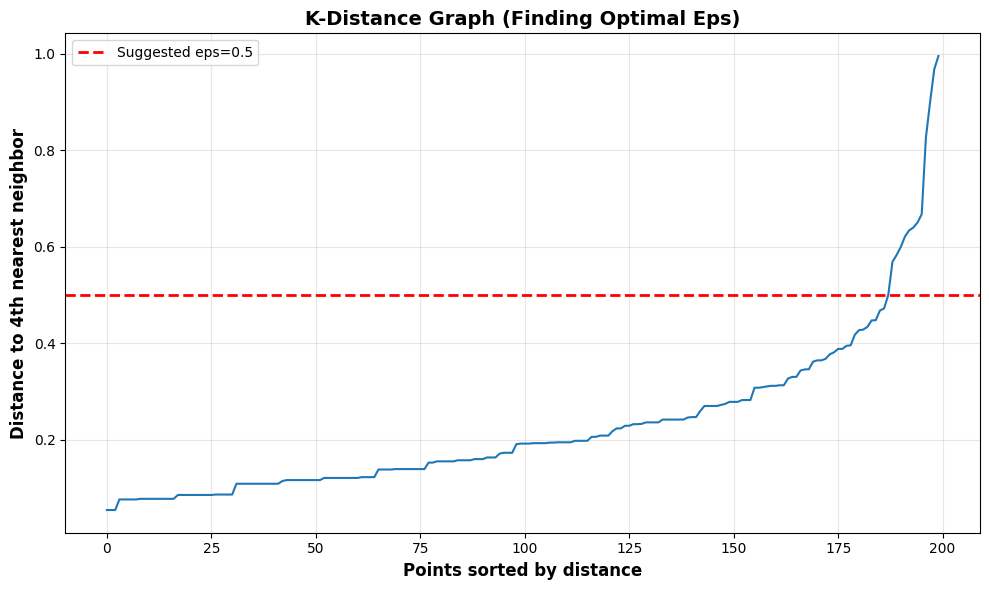


✓ Optimal eps identified: 0.5
✓ Reasoning: Sharp increase in distance at eps ≈ 0.5


In [9]:
# Calculate k-nearest neighbors distances (k = min_samples)
k = 4  # Typical choice: 2*dimensions

neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_scaled)

distances, indices = neighbors.kneighbors(X_scaled)

# Sort distances (k-th nearest neighbor)
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Suggested eps=0.5')
plt.xlabel('Points sorted by distance', fontweight='bold', fontsize=12)
plt.ylabel('Distance to 4th nearest neighbor', fontweight='bold', fontsize=12)
plt.title('K-Distance Graph (Finding Optimal Eps)', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_eps = 0.5  # From elbow in graph
print(f"\n✓ Optimal eps identified: {optimal_eps}")
print(f"✓ Reasoning: Sharp increase in distance at eps ≈ 0.5")

# STEP 6: TRAIN DBSCAN MODEL (DEFAULT)

### Training DBSCAN with eps={optimal_eps}, min_samples=4..."
💡 DBSCAN: Density-Based Spatial Clustering of Applications with Noise"

   • eps: Maximum distance between two points to be neighbors"
   
   • min_samples: Minimum points to form a dense region (cluster)"

   • Automatically detects outliers as noise!"

In [10]:
# Train DBSCAN
dbscan_default = DBSCAN(eps=optimal_eps, min_samples=4)
y_dbscan = dbscan_default.fit_predict(X_scaled)

In [11]:
# Get cluster info
n_clusters = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)
n_noise = list(y_dbscan).count(-1)

print(f"\n✓ Model trained successfully!")
print(f"✓ Number of clusters: {n_clusters}")
print(f"✓ Number of outliers (noise): {n_noise}")
print(f"✓ Outlier percentage: {n_noise/len(X)*100:.1f}%")


✓ Model trained successfully!
✓ Number of clusters: 2
✓ Number of outliers (noise): 8
✓ Outlier percentage: 4.0%


In [12]:
# Calculate metrics (excluding noise points)
if n_clusters > 1:
    # Silhouette score (excluding noise)
    mask = y_dbscan != -1
    if mask.sum() > 0:
        silhouette_avg = silhouette_score(X_scaled[mask], y_dbscan[mask])
        davies_bouldin = davies_bouldin_score(X_scaled[mask], y_dbscan[mask])

        print(f"\n--- Clustering Quality Metrics (excluding outliers) ---")
        print(f"✓ Silhouette Score: {silhouette_avg:.3f}")
        print(f"✓ Davies-Bouldin Index: {davies_bouldin:.3f}")


--- Clustering Quality Metrics (excluding outliers) ---
✓ Silhouette Score: 0.388
✓ Davies-Bouldin Index: 0.789


# STEP 7: VISUALIZE DBSCAN CLUSTERS

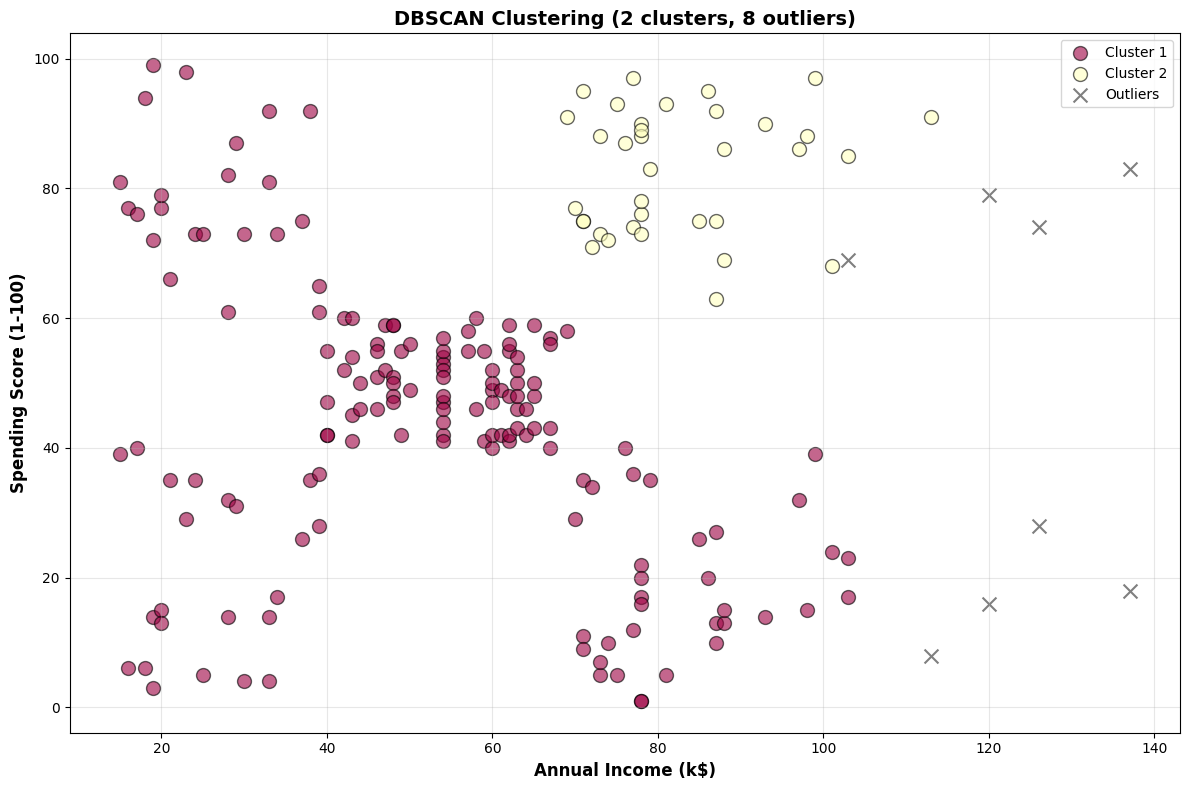

In [13]:
plt.figure(figsize=(12, 8))

# Get unique clusters (including noise = -1)
unique_labels = set(y_dbscan)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points (outliers)
        cluster_mask = y_dbscan == label
        plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1],
                   s=100, c='black', marker='x',
                   label='Outliers', alpha=0.5)
    else:
        # Cluster points
        cluster_mask = y_dbscan == label
        plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1],
                   s=100, c=[color],
                   label=f'Cluster {label+1}',
                   alpha=0.6, edgecolors='black')

plt.xlabel('Annual Income (k$)', fontweight='bold', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontweight='bold', fontsize=12)
plt.title(f'DBSCAN Clustering ({n_clusters} clusters, {n_noise} outliers)',
          fontweight='bold', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# STEP 8: PARAMETER TUNING (TEST DIFFERENT EPS & MIN_SAMPLES)


In [14]:
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [3, 4, 5]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Calculate silhouette (if more than 1 cluster and some non-noise points)
        if n_clusters > 1:
            mask = labels != -1
            if mask.sum() > 1:
                silhouette = silhouette_score(X_scaled[mask], labels[mask])
            else:
                silhouette = -1
        else:
            silhouette = -1

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette
        })

        print(f"eps={eps:.1f}, min_samples={min_samples}: "
              f"Clusters={n_clusters}, Noise={n_noise}, Silhouette={silhouette:.3f}")

# Find best parameters
results_df = pd.DataFrame(results)
best_idx = results_df['silhouette'].idxmax()
best_params = results_df.loc[best_idx]

print(f"\n✓ Best parameters:")
print(f"  eps: {best_params['eps']}")
print(f"  min_samples: {best_params['min_samples']}")
print(f"  Silhouette Score: {best_params['silhouette']:.3f}")


eps=0.3, min_samples=3: Clusters=9, Noise=14, Silhouette=0.472
eps=0.3, min_samples=4: Clusters=8, Noise=23, Silhouette=0.520
eps=0.3, min_samples=5: Clusters=7, Noise=35, Silhouette=0.524
eps=0.4, min_samples=3: Clusters=4, Noise=10, Silhouette=0.395
eps=0.4, min_samples=4: Clusters=3, Noise=14, Silhouette=0.458
eps=0.4, min_samples=5: Clusters=4, Noise=15, Silhouette=0.478
eps=0.5, min_samples=3: Clusters=2, Noise=7, Silhouette=0.389
eps=0.5, min_samples=4: Clusters=2, Noise=8, Silhouette=0.388
eps=0.5, min_samples=5: Clusters=2, Noise=8, Silhouette=0.388
eps=0.6, min_samples=3: Clusters=1, Noise=0, Silhouette=-1.000
eps=0.6, min_samples=4: Clusters=1, Noise=5, Silhouette=-1.000
eps=0.6, min_samples=5: Clusters=1, Noise=5, Silhouette=-1.000
eps=0.7, min_samples=3: Clusters=1, Noise=0, Silhouette=-1.000
eps=0.7, min_samples=4: Clusters=1, Noise=0, Silhouette=-1.000
eps=0.7, min_samples=5: Clusters=1, Noise=0, Silhouette=-1.000

✓ Best parameters:
  eps: 0.3
  min_samples: 5.0
  Silhou

In [15]:
# Train best model
dbscan_best = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
y_dbscan_best = dbscan_best.fit_predict(X_scaled)

In [16]:
n_clusters_best = len(set(y_dbscan_best)) - (1 if -1 in y_dbscan_best else 0)
n_noise_best = list(y_dbscan_best).count(-1)

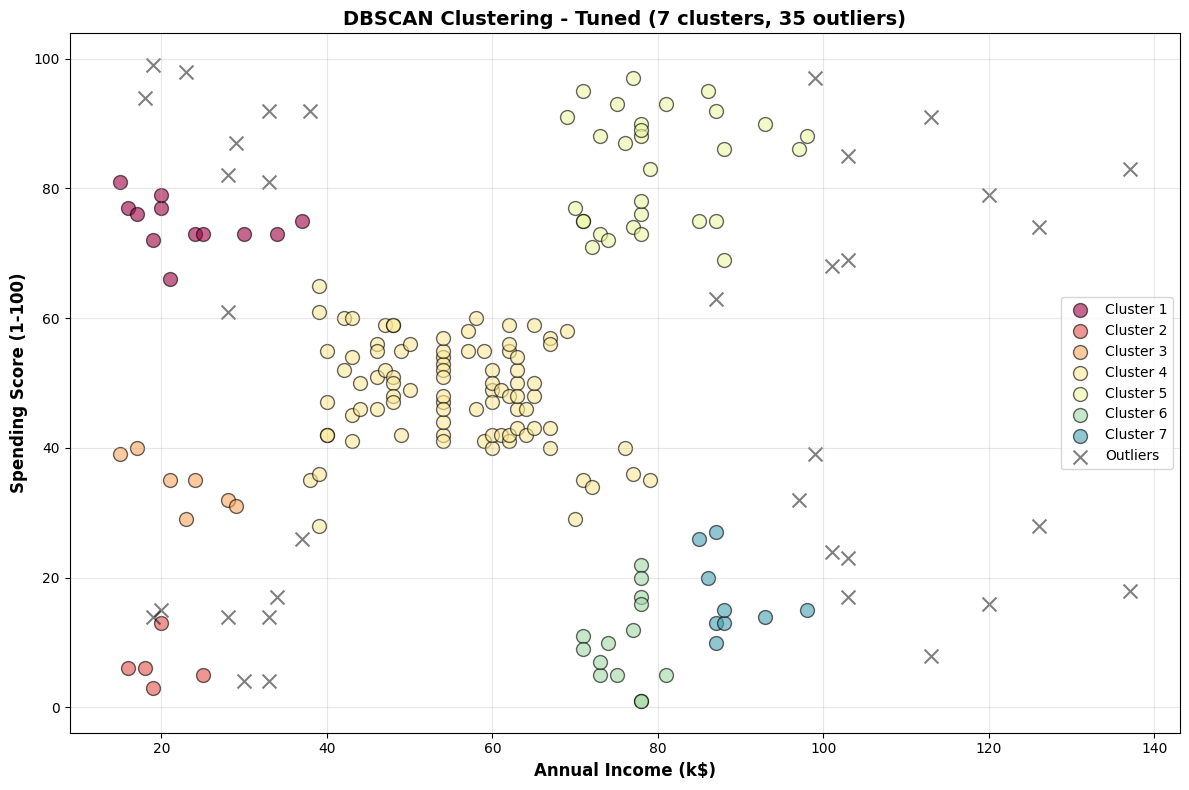

In [17]:
# Visualize best model
plt.figure(figsize=(12, 8))

unique_labels = set(y_dbscan_best)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        cluster_mask = y_dbscan_best == label
        plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1],
                   s=100, c='black', marker='x',
                   label='Outliers', alpha=0.5)
    else:
        cluster_mask = y_dbscan_best == label
        plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1],
                   s=100, c=[color],
                   label=f'Cluster {label+1}',
                   alpha=0.6, edgecolors='black')

plt.xlabel('Annual Income (k$)', fontweight='bold', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontweight='bold', fontsize=12)
plt.title(f'DBSCAN Clustering - Tuned ({n_clusters_best} clusters, {n_noise_best} outliers)',
          fontweight='bold', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# STEP 9: COMPARE DBSCAN VS K-MEANS


--- Algorithm Comparison ---


                  Metric K-Means DBSCAN
      Number of Clusters       5      7
       Outliers Detected       0     35
        Silhouette Score   0.555  0.524
Handles Arbitrary Shapes      No    Yes
       Needs K Parameter     Yes     No


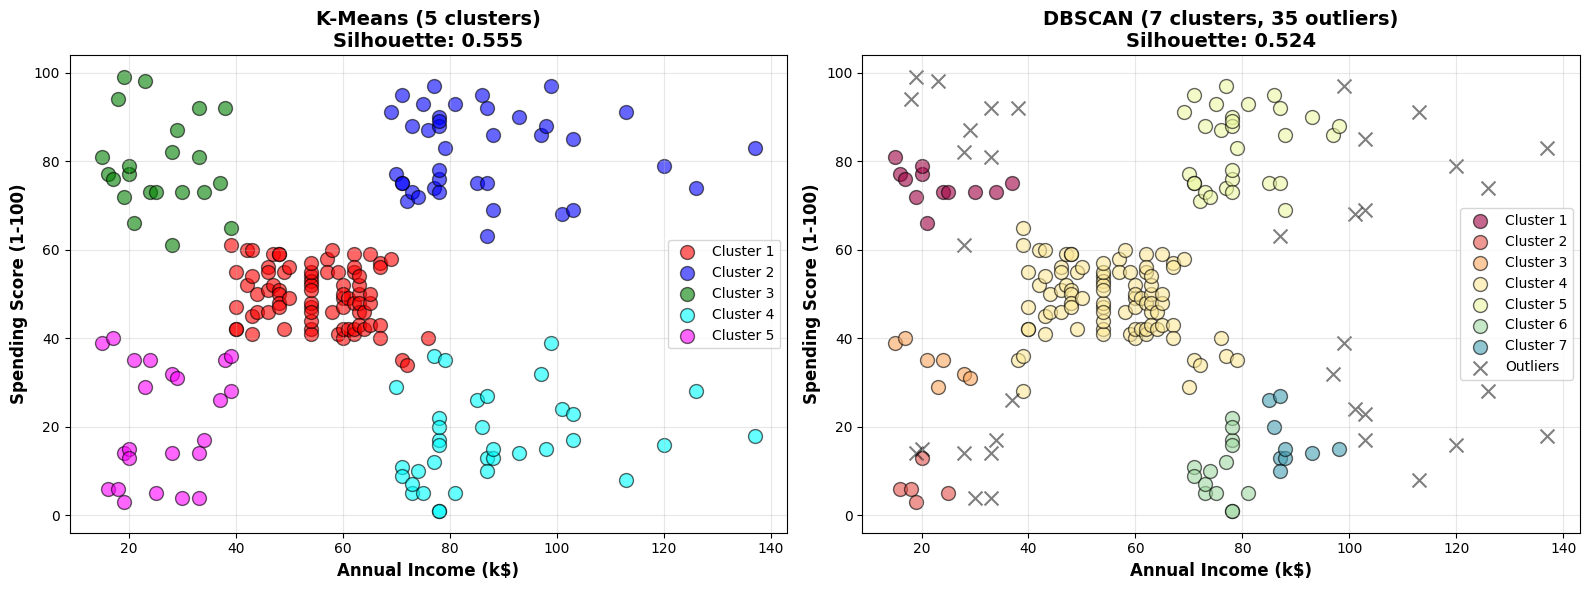

In [18]:
# Run K-Means for comparison
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

# Calculate metrics for both
mask_dbscan = y_dbscan_best != -1
silhouette_dbscan = silhouette_score(X_scaled[mask_dbscan], y_dbscan_best[mask_dbscan])

silhouette_kmeans = silhouette_score(X_scaled, y_kmeans)

print("\n--- Algorithm Comparison ---")
comparison = pd.DataFrame({
    'Metric': ['Number of Clusters', 'Outliers Detected', 'Silhouette Score',
               'Handles Arbitrary Shapes', 'Needs K Parameter'],
    'K-Means': [5, 0, f'{silhouette_kmeans:.3f}', 'No', 'Yes'],
    'DBSCAN': [n_clusters_best, n_noise_best, f'{silhouette_dbscan:.3f}', 'Yes', 'No']
})

print("\n")
print(comparison.to_string(index=False))

# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means plot
colors_kmeans = ['red', 'blue', 'green', 'cyan', 'magenta']
for i in range(5):
    cluster_points = X[y_kmeans == i]
    axes[0].scatter(cluster_points[:, 0], cluster_points[:, 1],
                   s=100, c=colors_kmeans[i],
                   label=f'Cluster {i+1}',
                   alpha=0.6, edgecolors='black')

axes[0].set_xlabel('Annual Income (k$)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Spending Score (1-100)', fontweight='bold', fontsize=12)
axes[0].set_title(f'K-Means (5 clusters)\nSilhouette: {silhouette_kmeans:.3f}',
                 fontweight='bold', fontsize=14)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# DBSCAN plot
colors_dbscan = plt.cm.Spectral(np.linspace(0, 1, n_clusters_best + 1))
for label in set(y_dbscan_best):
    if label == -1:
        cluster_mask = y_dbscan_best == label
        axes[1].scatter(X[cluster_mask, 0], X[cluster_mask, 1],
                       s=100, c='black', marker='x',
                       label='Outliers', alpha=0.5)
    else:
        cluster_mask = y_dbscan_best == label
        axes[1].scatter(X[cluster_mask, 0], X[cluster_mask, 1],
                       s=100, c=[colors_dbscan[label]],
                       label=f'Cluster {label+1}',
                       alpha=0.6, edgecolors='black')

axes[1].set_xlabel('Annual Income (k$)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Spending Score (1-100)', fontweight='bold', fontsize=12)
axes[1].set_title(f'DBSCAN ({n_clusters_best} clusters, {n_noise_best} outliers)\nSilhouette: {silhouette_dbscan:.3f}',
                 fontweight='bold', fontsize=14)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 10: BUSINESS INSIGHTS

In [19]:
# Add cluster labels to dataframe
df['DBSCAN_Cluster'] = y_dbscan_best
df['K-Means_Cluster'] = y_kmeans

# Identify outliers
outliers = df[df['DBSCAN_Cluster'] == -1]

print(f"\n💡 DBSCAN IDENTIFIED {n_noise_best} OUTLIERS:")
print("\n--- Outlier Characteristics ---")
if len(outliers) > 0:
    print(f"Average Age: {outliers['Age'].mean():.1f} years")
    print(f"Average Income: ${outliers['Annual Income (k$)'].mean():.1f}k")
    print(f"Average Spending Score: {outliers['Spending Score (1-100)'].mean():.1f}/100")
    print(f"\nThese customers don't fit typical patterns!")
    print("Business action: Investigate individually, may need special treatment")

print(f"\n✅ DBSCAN ADVANTAGES OVER K-MEANS:")
print("   • Automatically detects outliers (fraud detection!)")
print("   • Handles arbitrary cluster shapes (not just circular)")
print("   • No need to specify number of clusters (K)")
print("   • Works well with varying cluster densities")

print(f"\n⚠️ DBSCAN DISADVANTAGES:")
print("   • Sensitive to eps and min_samples parameters")
print("   • Struggles with varying densities")
print("   • Slower than K-Means on large datasets")


💡 DBSCAN IDENTIFIED 35 OUTLIERS:

--- Outlier Characteristics ---
Average Age: 37.7 years
Average Income: $70.6k
Average Spending Score: 51.7/100

These customers don't fit typical patterns!
Business action: Investigate individually, may need special treatment

✅ DBSCAN ADVANTAGES OVER K-MEANS:
   • Automatically detects outliers (fraud detection!)
   • Handles arbitrary cluster shapes (not just circular)
   • No need to specify number of clusters (K)
   • Works well with varying cluster densities

⚠️ DBSCAN DISADVANTAGES:
   • Sensitive to eps and min_samples parameters
   • Struggles with varying densities
   • Slower than K-Means on large datasets
